### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error

import statsmodels
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa import stattools
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')


sns.set()
plt.rcParams['figure.figsize'] = (12, 6)

### Load Data

In [2]:
df = pd.read_csv('../data/TG_STAID002759.txt',header=15,sep=',', index_col=2, parse_dates=True)

In [3]:
df.head()

,STAID,SOUID,TG,Q_TG
DATE,,,,
1876-01-01,2759,27488,22,0
1876-01-02,2759,27488,25,0
1876-01-03,2759,27488,3,0
1876-01-04,2759,27488,-58,0
1876-01-05,2759,27488,-98,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53416 entries, 1876-01-01 to 2022-03-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   STAID   53416 non-null  int64
 1    SOUID  53416 non-null  int64
 2      TG   53416 non-null  int64
 3    Q_TG   53416 non-null  int64
dtypes: int64(4)
memory usage: 2.0 MB


In [5]:
for col in df.columns:
    if col == '   TG':
        continue
    print(f'The data structure of {col} is {df[col].unique()}')

The data structure of STAID is [2759]
The data structure of  SOUID is [27488 28124 11448]
The data structure of  Q_TG is [0 9 1]


### Clean the Data

In [6]:
def clean_data(df):
    # rename the columns to get rid of unnecessary spaces in naming
    df.columns = df.columns.str.replace(' ','')
    # resclae the TG data
    df['TG'] = df['TG'] * 0.1
    # get rid of suspect and missing values 
    df = df[df['Q_TG'] == 0]
    
    return df

In [7]:
df = clean_data(df)

In [8]:
df.sample(10)

,STAID,SOUID,TG,Q_TG
DATE,,,,
1902-12-15,2759,27488,-6.0,0
2014-08-15,2759,11448,16.6,0
1940-02-24,2759,27488,5.4,0
1936-03-17,2759,27488,3.2,0
1976-04-12,2759,11448,9.8,0
1967-11-17,2759,11448,4.4,0
1926-03-17,2759,27488,1.7,0
1923-10-14,2759,27488,8.6,0
1925-05-09,2759,27488,15.7,0


### Feature Engineering

In [9]:
# Define the timestep
df['timestep'] = range(len(df))

In [10]:
df.head()

,STAID,SOUID,TG,Q_TG,timestep
DATE,,,,,
1876-01-01,2759,27488,2.2,0,0
1876-01-02,2759,27488,2.5,0,1
1876-01-03,2759,27488,0.3,0,2
1876-01-04,2759,27488,-5.8,0,3
1876-01-05,2759,27488,-9.8,0,4


In [11]:
# One-Hot-Encoding the day
seasonal_dummies = pd.get_dummies(df.index.dayofyear,
                                  prefix='dayOfyear',
                                  drop_first=True).set_index(df.index)
# join the dummies with the dataframe
df = df.join(seasonal_dummies)
df.head(3)

,STAID,SOUID,TG,Q_TG,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,...,dayOfyear_357,dayOfyear_358,dayOfyear_359,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2759,27488,2.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-02,2759,27488,2.5,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-03,2759,27488,0.3,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train-Test Split

In [12]:
df_train = df[:-365]
df_test = df[-365:]

In [13]:
df_test.tail(2)

,STAID,SOUID,TG,Q_TG,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,...,dayOfyear_357,dayOfyear_358,dayOfyear_359,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366
DATE,,,,,,,,,,,,,,,,,,,,,
2022-03-29,2759,11448,8.0,0,53217,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-30,2759,11448,5.3,0,53218,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Visualize the Data

In [142]:
def plot_TG(df,title='The daily average temperature at BERLIN-TEMPELHOF station',xlim =False,
            start_date='1876-01-01' , end_date='1896-01-01',labels=[],save=False,filename='plot'):
    df.plot()
    plt.title(title)
    plt.ylabel('Temperature(C)')
    if xlim:
        plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
    if not labels==[]:
        plt.legend(labels)
    if save:
        plt.savefig(f'../figures/{filename}',dpi=250)
    plt.show() 

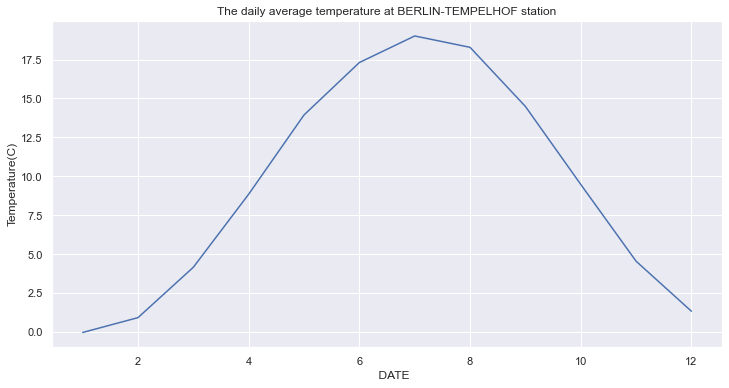

In [139]:
plot_TG(df_train.groupby(df_train.index.month).mean()['TG'])

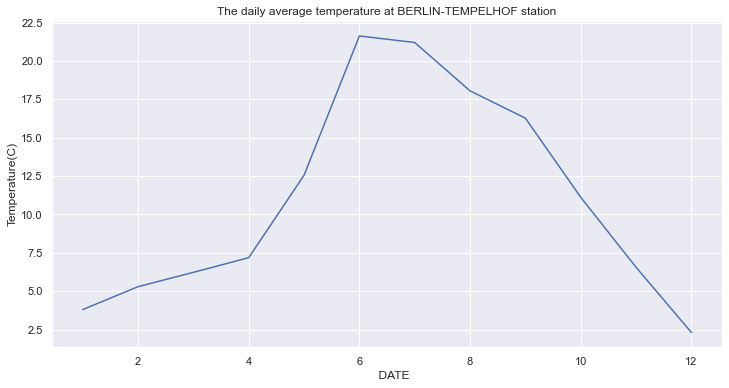

In [16]:
plot_TG(df_test.groupby(df_test.index.month).mean()['TG'])

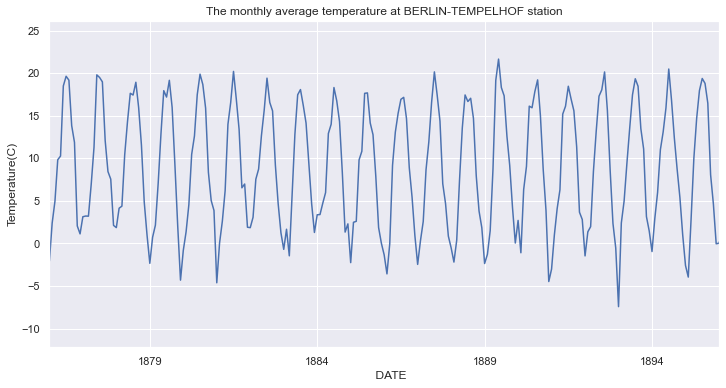

In [17]:
plot_TG(df_train.resample('M').mean()['TG'],xlim=True,
        title='The monthly average temperature at BERLIN-TEMPELHOF station')

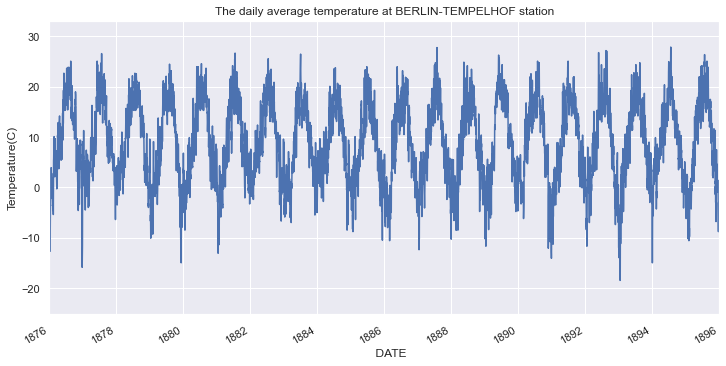

In [18]:
plot_TG(df['TG'],xlim=True)

### Build a Model Based on AR

#### Model the Trend

In [19]:
X_train = df_train[['timestep']]
y_train = df_train['TG']

In [20]:
m = LinearRegression()
m.fit(X_train, y_train);

In [21]:
df_train['trend'] = m.predict(X_train)

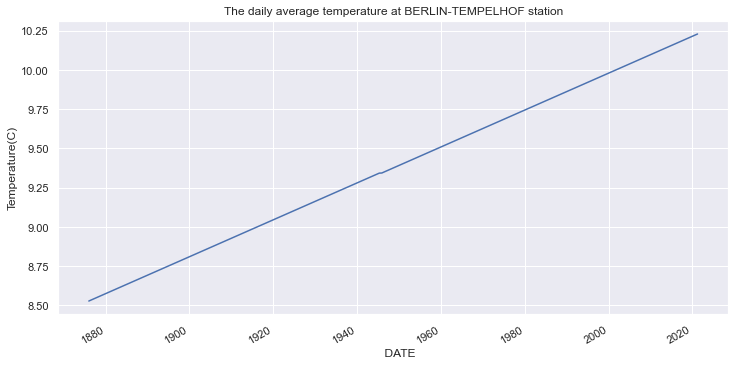

In [22]:
plot_TG(df_train['trend'])

#### Model the Trend_Seasonal

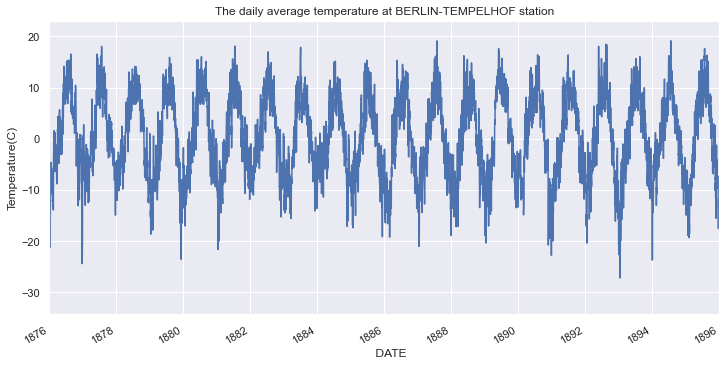

In [23]:
df_train['wo_trend'] = df_train['TG'] - df_train['trend']

plot_TG(df_train['wo_trend'],xlim=True)

In [24]:
X_train = df_train.iloc[:,4:370]
X_train.head()

,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,dayOfyear_7,dayOfyear_8,dayOfyear_9,dayOfyear_10,...,dayOfyear_357,dayOfyear_358,dayOfyear_359,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
m = LinearRegression()
m.fit(X_train, y_train);

In [26]:
df_train['trend_seasonal'] = m.predict(X_train)
df_train.head()

,STAID,SOUID,TG,Q_TG,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,...,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,trend,wo_trend,trend_seasonal
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2759,27488,2.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.527669,-6.327669,-0.749132
1876-01-02,2759,27488,2.5,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,8.527701,-6.027701,-0.501187
1876-01-03,2759,27488,0.3,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,8.527733,-8.227733,-0.363516
1876-01-04,2759,27488,-5.8,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,8.527765,-14.327765,-0.453926
1876-01-05,2759,27488,-9.8,0,4,0,0,0,1,0,...,0,0,0,0,0,0,0,8.527798,-18.327798,-0.649817


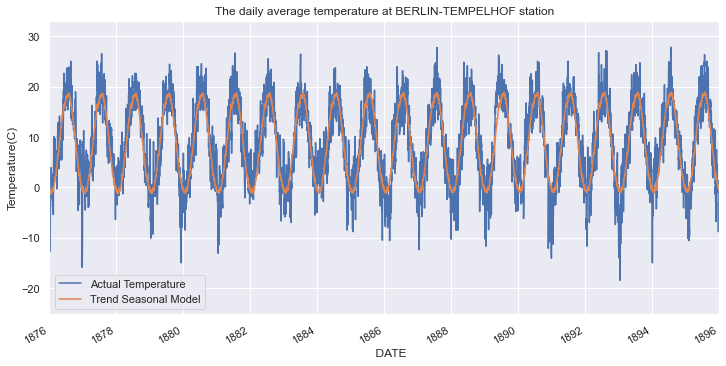

In [119]:
plot_TG(df_train[['TG','trend_seasonal']],xlim=True,labels=['Actual Temperature','Trend Seasonal Model'])

#### Model remainder

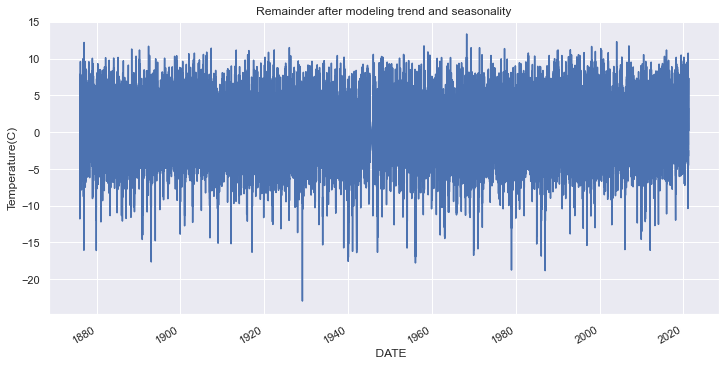

In [28]:
df_train['remainder'] = df_train['TG'] - df_train['trend_seasonal']
plot_TG(df_train['remainder'],title='Remainder after modeling trend and seasonality')

is the reminder stationary? 

##### Augmented Dickey Fuller Test

In [29]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=0.01; CI=99%) 
            {round(levels['5%'],2)} (p=0.05; CI=95%)
            {round(levels['10%'],2)} (p=0.1 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)

In [30]:
print_adf(df_train['remainder'])

   
            adf: -37.99
            p: 0.0 
            used lag: 21 
            number of observations: 52832
            -3.43 (p=0.01; CI=99%) 
            -2.86 (p=0.05; CI=95%)
            -2.57 (p=0.1 CI=90%) 
            information criterion (AIC): 234296.11318372248
            


##### Determine Autocorrelation and Partial Autocorrelation

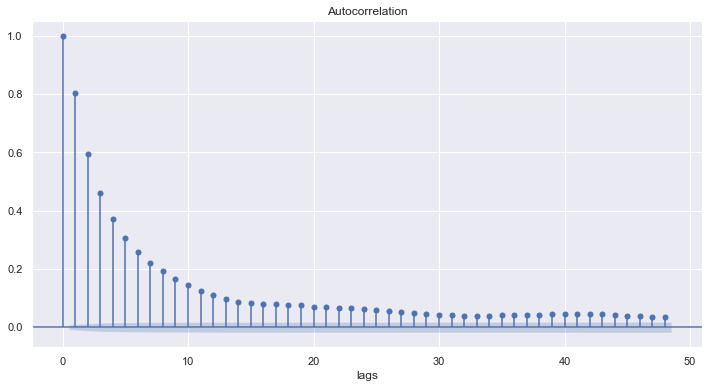

In [31]:
# plot autocorrelation function
plot_acf(df_train['remainder'])
plt.xlabel('lags');

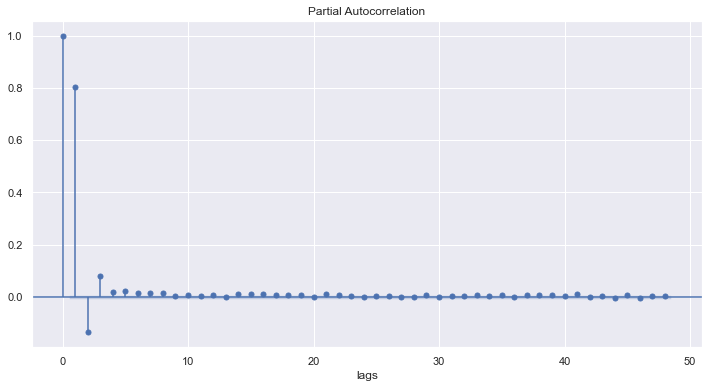

In [32]:
# plot partial autocorrelation function
plot_pacf(df_train['remainder'])
plt.xlabel('lags');
#plt.ylim([-0.15,0.2])

It seems that we need 3 lags

In [33]:
# prepare lags for remainder
df_train['lag1'] = df_train['remainder'].shift(1) 
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3) 
df_train.dropna(inplace=True)

In [34]:
df_train[['remainder','lag1','lag2','lag3']].head(4)

,remainder,lag1,lag2,lag3
DATE,,,,
1876-01-04,-5.346074,0.663516,3.001187,2.949132
1876-01-05,-9.150183,-5.346074,0.663516,3.001187
1876-01-06,-6.856347,-9.150183,-5.346074,0.663516
1876-01-07,-5.609087,-6.856347,-9.150183,-5.346074


In [35]:
df_train[['remainder','lag1','lag2','lag3']].corr()

,remainder,lag1,lag2,lag3
remainder,1.000000,0.802845,0.595888,0.461476
lag1,0.802845,1.000000,0.802829,0.595900
lag2,0.595888,0.802829,1.000000,0.802851
lag3,0.461476,0.595900,0.802851,1.000000


##### Model remainder with different AR models

###### AR1

In [36]:
ar1_model = AutoReg(endog=df_train['remainder'], lags=1).fit()
ar1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                52851
Model:                     AutoReg(1)   Log Likelihood             -117968.842
Method:               Conditional MLE   S.D. of innovations              2.255
Date:                Thu, 16 Jun 2022   AIC                              1.627
Time:                        10:37:55   BIC                              1.627
Sample:                             1   HQIC                             1.627
                                52851                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0002      0.010      0.019      0.985      -0.019       0.019
remainder.L1     0.8029      0.003    309.601      0.000       0.798       0.808
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2455           +0.0000j            1.2455            0.0000
-----------------------------------------------------------------------------
"""

In [37]:
X_train_ar1 = df_train.drop(columns=['STAID','SOUID','TG','Q_TG','trend',
                                      'wo_trend','trend_seasonal','remainder','lag2','lag3'])
y_train_ar1 = df_train['TG']

In [38]:
X_train_ar1.head(1)

,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,dayOfyear_7,dayOfyear_8,dayOfyear_9,dayOfyear_10,...,dayOfyear_358,dayOfyear_359,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,lag1
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-04,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.663516


In [39]:
# Create and fit the ar1 model
m_ar1 = LinearRegression()
m_ar1.fit(X_train_ar1, y_train_ar1)
ar1_score = m_ar1.score(X_train_ar1,y_train_ar1)
print(ar1_score)

0.9180649466529522


###### AR2

In [40]:
ar2_model = AutoReg(endog=df_train['remainder'], lags=2).fit()
ar2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                52851
Model:                     AutoReg(2)   Log Likelihood             -117465.800
Method:               Conditional MLE   S.D. of innovations              2.234
Date:                Thu, 16 Jun 2022   AIC                              1.608
Time:                        10:37:57   BIC                              1.608
Sample:                             2   HQIC                             1.608
                                52851                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0002      0.010      0.025      0.980      -0.019       0.019
remainder.L1     0.9126      0.004    211.806      0.000       0.904       0.921
remainder.L2    -0.1368      0.004    -31.741      0.000      -0.145      -0.128
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3819           +0.0000j            1.3819            0.0000
AR.2            5.2911           +0.0000j            5.2911            0.0000
-----------------------------------------------------------------------------
"""

In [41]:
X_train_ar2 = df_train.drop(columns=['STAID','SOUID','TG','Q_TG','trend',
                                      'wo_trend','trend_seasonal','remainder','lag3'])
y_train_ar2 = df_train['TG']

In [42]:
# Create and fit the ar2 model
m_ar2 = LinearRegression()
m_ar2.fit(X_train_ar2, y_train_ar2)
ar2_score = m_ar2.score(X_train_ar2,y_train_ar2)
print(ar2_score)

0.9196003365837471


###### AR3

In [43]:
ar3_model = AutoReg(endog=df_train['remainder'], lags=3).fit()
ar3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                52851
Model:                     AutoReg(3)   Log Likelihood             -117299.432
Method:               Conditional MLE   S.D. of innovations              2.227
Date:                Thu, 16 Jun 2022   AIC                              1.601
Time:                        10:37:58   BIC                              1.602
Sample:                             3   HQIC                             1.602
                                52851                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0002      0.010      0.025      0.980      -0.019       0.019
remainder.L1     0.9234      0.004    212.948      0.000       0.915       0.932
remainder.L2    -0.2087      0.006    -35.729      0.000      -0.220      -0.197
remainder.L3     0.0788      0.004     18.171      0.000       0.070       0.087
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2731           -0.0000j            1.2731           -0.0000
AR.2            0.6876           -3.0814j            3.1572           -0.2151
AR.3            0.6876           +3.0814j            3.1572            0.2151
-----------------------------------------------------------------------------
"""

In [44]:
X_train_ar3 = df_train.drop(columns=['STAID','SOUID','TG','Q_TG','trend',
                                      'wo_trend','trend_seasonal','remainder'])
y_train_ar3 = df_train['TG']

In [45]:
# Create and fit the ar1 model
m_ar3 = LinearRegression()
m_ar3.fit(X_train_ar3, y_train_ar3)
ar3_score = m_ar3.score(X_train_ar3,y_train_ar3)
print(ar3_score)

0.920099364403212


In [46]:
# compare the score of all the AR models
ar_scores = [ar1_score,ar2_score,ar3_score]
models = ['AR1','AR2','AR3']
#data = ar_scores.append(models)
pd.DataFrame({'Model':models,'Score':ar_scores}).set_index('Model')


,Score
Model,
AR1,0.918065
AR2,0.919600
AR3,0.920099


### Run the Full Model (AR3)

In [47]:
X_train_full = df_train.drop(columns=['STAID','SOUID','TG','Q_TG','trend',
                                      'wo_trend','trend_seasonal','remainder'])
y_train_full = df_train['TG']

In [48]:
X_train_full.head(2)

,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,dayOfyear_7,dayOfyear_8,dayOfyear_9,dayOfyear_10,...,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-04,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.663516,3.001187,2.949132
1876-01-05,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-5.346074,0.663516,3.001187


In [49]:
# Create and fit the full model
m_full = LinearRegression()
m_full.fit(X_train_full, y_train_full);

In [50]:
# Create predictions with full model
df_train['predictions_full_model'] = m_full.predict(X_train_full)
df_train.head()

,STAID,SOUID,TG,Q_TG,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,...,dayOfyear_365,dayOfyear_366,trend,wo_trend,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-04,2759,27488,-5.8,0,3,0,0,1,0,0,...,0,0,8.527765,-14.327765,-0.453926,-5.346074,0.663516,3.001187,2.949132,-0.235815
1876-01-05,2759,27488,-9.8,0,4,0,0,0,1,0,...,0,0,8.527798,-18.327798,-0.649817,-9.150183,-5.346074,0.663516,3.001187,-5.489668
1876-01-06,2759,27488,-7.7,0,5,0,0,0,0,1,...,0,0,8.527830,-16.227830,-0.843653,-6.856347,-9.150183,-5.346074,0.663516,-8.126139
1876-01-07,2759,27488,-6.6,0,6,0,0,0,0,0,...,0,0,8.527862,-15.127862,-0.990913,-5.609087,-6.856347,-9.150183,-5.346074,-5.834094
1876-01-08,2759,27488,-8.9,0,7,0,0,0,0,0,...,0,0,8.527894,-17.427894,-0.801872,-8.098128,-5.609087,-6.856347,-9.150183,-5.271864


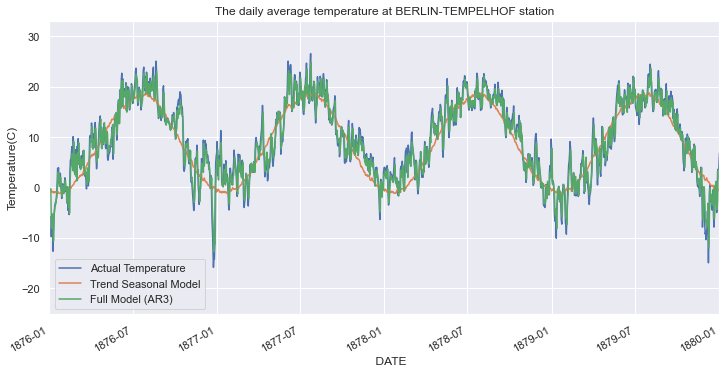

In [123]:
# compare the predictions vs TG for the trainig data
plot_TG(df_train[['TG','trend_seasonal','predictions_full_model']],xlim=True,
        start_date='1876-01-01',end_date='1880-01-01',labels=['Actual Temperature','Trend Seasonal Model','Full Model (AR3)'])

In [52]:
# Coefficinets pf the AR equation's terms
pd.DataFrame(m_full.coef_.reshape(1,369), columns=X_train_full.columns)

,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,dayOfyear_7,dayOfyear_8,dayOfyear_9,dayOfyear_10,...,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,lag1,lag2,lag3
0,0.000033,0.296418,0.443739,0.344501,0.148578,-0.045291,-0.192584,-0.003576,-0.108403,-0.200217,...,0.954776,0.571984,0.702986,0.532608,0.498782,0.315301,-0.011752,0.923557,-0.208812,0.078795


### Evaluate The Full Model

In [53]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [54]:
# Create the time series split
time_series_split = ts_split.split(X_train_full, y_train_full) 

In [55]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=X_train_full, y=y_train_full,
                         cv=time_series_split)
result

array([0.90810605, 0.91488366, 0.91878954, 0.91390618, 0.92307493])

In [56]:
result.mean()

0.9157520736854708

### Test The Full Model

In [57]:
df_test.head(3)

,STAID,SOUID,TG,Q_TG,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,...,dayOfyear_357,dayOfyear_358,dayOfyear_359,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366
DATE,,,,,,,,,,,,,,,,,,,,,
2021-03-31,2759,11448,15.4,0,52854,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-01,2759,11448,11.7,0,52855,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-02,2759,11448,6.1,0,52856,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# define X_test and y_test
X_test = df_test.drop(columns=['STAID','SOUID','TG','Q_TG'])
y_test = df_test['TG']

In [59]:
X_test.head(3)

,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,dayOfyear_7,dayOfyear_8,dayOfyear_9,dayOfyear_10,...,dayOfyear_357,dayOfyear_358,dayOfyear_359,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366
DATE,,,,,,,,,,,,,,,,,,,,,
2021-03-31,52854,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-01,52855,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-04-02,52856,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# predict trend and seasonality
df_test['trend_seasonal'] = m.predict(X_test)

In [61]:
df_test.head(3)

,STAID,SOUID,TG,Q_TG,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,...,dayOfyear_358,dayOfyear_359,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,trend_seasonal
DATE,,,,,,,,,,,,,,,,,,,,,
2021-03-31,2759,11448,15.4,0,52854,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.641483
2021-04-01,2759,11448,11.7,0,52855,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.963552
2021-04-02,2759,11448,6.1,0,52856,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.860793


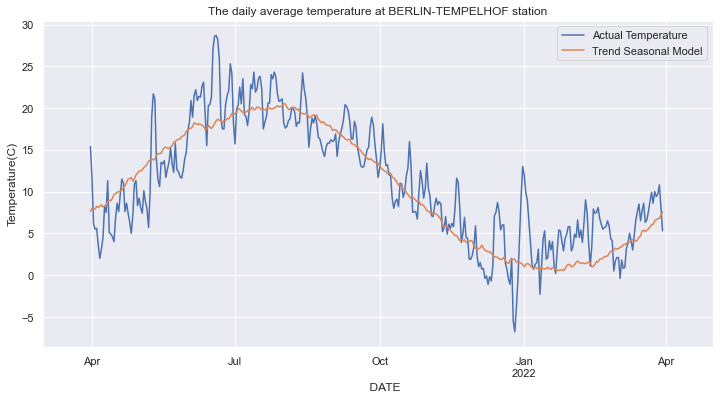

In [124]:
plot_TG(df_test[['TG','trend_seasonal']],xlim=True,
        start_date='2021-03-01',end_date='2022-05-01',labels=['Actual Temperature','Trend Seasonal Model'])

In [63]:
# calculate the remainder for the test set
df_test['remainder'] = df_test['TG'] - df_test['trend_seasonal']

In [64]:
# calculate lags for the remander
df_test['lag1'] = df_test['remainder'].shift(1) 
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3) 

In [65]:
df_test.head(4)

,STAID,SOUID,TG,Q_TG,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,...,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
2021-03-31,2759,11448,15.4,0,52854,0,0,0,0,0,...,0,0,0,0,0,7.641483,7.758517,NaN,NaN,NaN
2021-04-01,2759,11448,11.7,0,52855,0,0,0,0,0,...,0,0,0,0,0,7.963552,3.736448,7.758517,NaN,NaN
2021-04-02,2759,11448,6.1,0,52856,0,0,0,0,0,...,0,0,0,0,0,7.860793,-1.760793,3.736448,7.758517,NaN
2021-04-03,2759,11448,5.5,0,52857,0,0,0,0,0,...,0,0,0,0,0,7.910449,-2.410449,-1.760793,3.736448,7.758517


In [66]:
# assing X_test_full
X_test_full = df_test.drop(columns=['STAID','SOUID','TG','Q_TG','remainder','trend_seasonal'])

In [67]:
# filling the missing value from the beginning of the test lag
X_test_full.loc['2021-03-31', 'lag1'] = df_train.loc['2021-03-30', 'remainder']
X_test_full.loc['2021-03-31', 'lag2'] = df_train.loc['2021-03-29', 'remainder']
X_test_full.loc['2021-03-31', 'lag3'] = df_train.loc['2021-03-28', 'remainder']

X_test_full.loc['2021-04-01', 'lag2'] = df_train.loc['2021-03-30', 'remainder']
X_test_full.loc['2021-04-01', 'lag3'] = df_train.loc['2021-03-29', 'remainder']

X_test_full.loc['2021-04-02', 'lag3'] = df_train.loc['2021-03-30', 'remainder']

In [68]:
X_test_full.head(3)

,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,dayOfyear_7,dayOfyear_8,dayOfyear_9,dayOfyear_10,...,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
2021-03-31,52854,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7.343733,7.198527,0.909486
2021-04-01,52855,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7.758517,7.343733,7.198527
2021-04-02,52856,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.736448,7.758517,7.343733


In [69]:
# Create the predictions
df_test['predictions_full_model'] = m_full.predict(X_test_full)

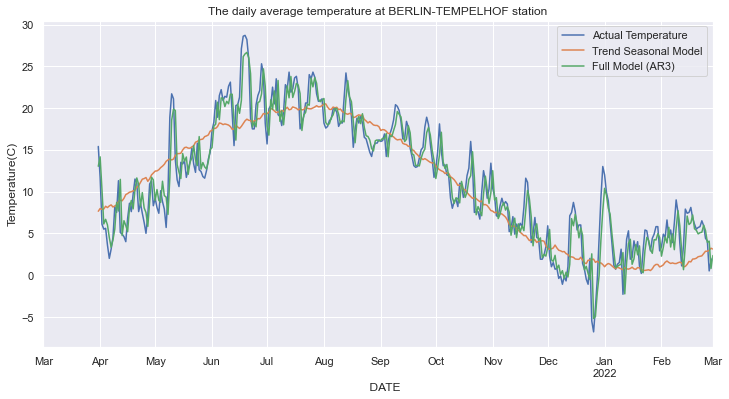

In [125]:
plot_TG(df_test[['TG','trend_seasonal','predictions_full_model']],xlim=True,
        start_date='2021-03-01',end_date='2022-03-01',labels=['Actual Temperature','Trend Seasonal Model','Full Model (AR3)'])

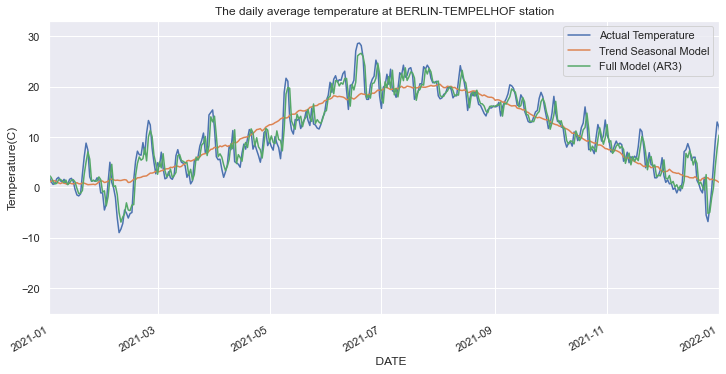

In [143]:
# Create the complete dataset and plot it
df_full = df_train[['TG', 'trend_seasonal', 'predictions_full_model']].append(df_test[['TG', 'trend_seasonal', 'predictions_full_model']])
plot_TG(df_full,xlim=True,start_date='2021-01-01',end_date='2022-01-01',
        labels=['Actual Temperature','Trend Seasonal Model','Full Model (AR3)'],
        save=True,filename='prediction_2021')

### Predict The Feature Using The Full Model

In [72]:
# combine train and test data
df_combined = df_train.drop(columns=['trend','wo_trend']).append(df_test)
df_combined.head()

,STAID,SOUID,TG,Q_TG,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,...,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-04,2759,27488,-5.8,0,3,0,0,1,0,0,...,0,0,0,0,-0.453926,-5.346074,0.663516,3.001187,2.949132,-0.235815
1876-01-05,2759,27488,-9.8,0,4,0,0,0,1,0,...,0,0,0,0,-0.649817,-9.150183,-5.346074,0.663516,3.001187,-5.489668
1876-01-06,2759,27488,-7.7,0,5,0,0,0,0,1,...,0,0,0,0,-0.843653,-6.856347,-9.150183,-5.346074,0.663516,-8.126139
1876-01-07,2759,27488,-6.6,0,6,0,0,0,0,0,...,0,0,0,0,-0.990913,-5.609087,-6.856347,-9.150183,-5.346074,-5.834094
1876-01-08,2759,27488,-8.9,0,7,0,0,0,0,0,...,0,0,0,0,-0.801872,-8.098128,-5.609087,-6.856347,-9.150183,-5.271864


In [73]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['STAID','SOUID','TG','Q_TG','trend_seasonal','remainder','predictions_full_model'])
y_combined = df_combined['TG']

In [74]:
# filling the missing value from the beginning of the test lag and extract the value from the train data
X_combined.loc['2021-03-31', 'lag1'] = df_train.loc['2021-03-30', 'remainder']
X_combined.loc['2021-03-31', 'lag2'] = df_train.loc['2021-03-29', 'remainder']
X_combined.loc['2021-03-31', 'lag3'] = df_train.loc['2021-03-28', 'remainder']

X_combined.loc['2021-04-01', 'lag2'] = df_train.loc['2021-03-30', 'remainder']
X_combined.loc['2021-04-01', 'lag3'] = df_train.loc['2021-03-29', 'remainder']

X_combined.loc['2021-04-02', 'lag3'] = df_train.loc['2021-03-30', 'remainder']

In [75]:
X_combined.tail(1)

,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,dayOfyear_7,dayOfyear_8,dayOfyear_9,dayOfyear_10,...,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
2022-03-30,53218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.786512,3.997471,2.981718


In [76]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined);

In [77]:
# What is the first date in the future? --> 2022-03-31 (it is the 90th day of the year)
timestep = df_combined['timestep'].max() + 1
days = [0] * 88 + [1] + [0] * 276
lag1 = df_combined.loc['2022-03-30', 'remainder']
lag2 = df_combined.loc['2022-03-29', 'remainder']
lag3 = df_combined.loc['2022-03-28', 'remainder']

In [78]:
X_future = [timestep]
X_future.extend(days)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)

In [79]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns
X_future

,timestep,dayOfyear_2,dayOfyear_3,dayOfyear_4,dayOfyear_5,dayOfyear_6,dayOfyear_7,dayOfyear_8,dayOfyear_9,dayOfyear_10,...,dayOfyear_360,dayOfyear_361,dayOfyear_362,dayOfyear_363,dayOfyear_364,dayOfyear_365,dayOfyear_366,lag1,lag2,lag3
0,53219,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.268282,0.786512,3.997471


In [80]:
print(f'The daily average temperature on 2022-03-31 would be: \
{round(m_combined.predict(X_future)[0],3)}')

The daily average temperature on 2022-03-31 would be: 5.762


### ARIMA Model

In [81]:
# Create and fit an ARIMA model (p=3, d=0 , q=3)
arima = ARIMA(endog= df_train['remainder'], order = (3,0,3)).fit()

In [82]:
# Create the predictions
df_train['predictions_arima'] = df_train['trend_seasonal'] + arima.predict()

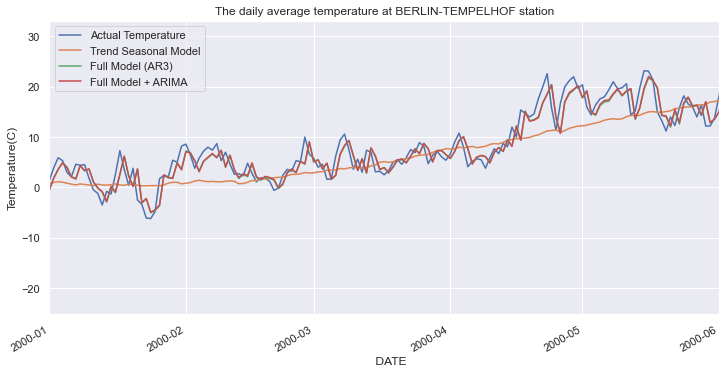

In [129]:
# Compare the trend sesonal model, full model (AR3) and ARIMA model (q=3,p=3)
plot_TG(df_train[['TG','trend_seasonal','predictions_full_model','predictions_arima']],xlim=True,
       start_date='2000-01-01' , end_date='2000-06-01',labels=['Actual Temperature','Trend Seasonal Model','Full Model (AR3)', 'Full Model + ARIMA'])

In [84]:
trend_sesonal_error = round(mean_absolute_error(df_train['TG'], df_train['trend_seasonal']),4)
full_error = round(mean_absolute_error(df_train['TG'], df_train['predictions_full_model']),4)
arima_error = round(mean_absolute_error(df_train['TG'], df_train['predictions_arima']),4)

In [85]:
print(f'Mean absolute error \nTrend seasonal model: {trend_sesonal_error}\nFull model(Trend seasonal + AR3): {full_error}\nFull model + ARIMA: {arima_error}')

Mean absolute error 
Trend seasonal model: 3.0023
Full model(Trend seasonal + AR3): 1.7332
Full model + ARIMA: 1.7323
